In [ ]:
!pip uninstall -y keras tensorflow librosa
# These particular libraries and their specific versions are required to run the code
!pip install keras==2.15.0 tensorflow==2.15.0 tf-keras==2.14.1 librosa==0.9.2
!pip list | grep keras
!pip list | grep tensorflow
!pip list | grep librosa


keras                            2.15.0
tf_keras                         2.17.0
tensorflow                       2.15.0
tensorflow-datasets              4.9.6
tensorflow-estimator             2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.37.1
tensorflow-metadata              1.15.0
tensorflow-probability           0.24.0
librosa                          0.9.2


In [ ]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# Import necessary libraries for preprocessing.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import timeit
from tqdm import tqdm

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, BatchNormalization, GRU
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LayerNormalization, Dense, MultiHeadAttention, Dropout, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths for input Data

Ravdess = "/content/drive/My Drive/Data/Ravdess/audio_speech_actors_01-24/"
Crema = "/content/drive/My Drive/Data/crema/AudioWAV/"


In [ ]:
# The input audio files for Ravdess is in directories, Preparaing the input and putting it in a dataframe for Ravdess

# Preparing data set

ravdess_directory_list = os.listdir(Ravdess)
print(ravdess_directory_list)


['Actor_23', 'Actor_20', 'Actor_24', 'Actor_22', 'Actor_21', 'Actor_18', 'Actor_10', 'Actor_13', 'Actor_12', 'Actor_17', 'Actor_11', 'Actor_16', 'Actor_15', 'Actor_19', 'Actor_14', 'Actor_04', 'Actor_07', 'Actor_03', 'Actor_08', 'Actor_01', 'Actor_06', 'Actor_05', 'Actor_09', 'Actor_02']


In [ ]:
# For processing audio files in Ravdess Dataset
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + i + '/' + f)


In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-03-02-02-01-02.wav
03
/content/drive/My Drive/Data/Ravdess/audio_speech_actors_01-24/Actor_23/03-01-08-01-01-01-23.wav
8
03-01-08-02-02-02-02.wav


In [ ]:
# Preparing final dataframe for Ravdess Dataset

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(Ravdess_df.head())
print("______________________________________________")
print(Ravdess_df.tail())
print("_______________________________________________")
print(Ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /content/drive/My Drive/Data/Ravdess/audio_spe...
1     happy  /content/drive/My Drive/Data/Ravdess/audio_spe...
2     angry  /content/drive/My Drive/Data/Ravdess/audio_spe...
3   neutral  /content/drive/My Drive/Data/Ravdess/audio_spe...
4   disgust  /content/drive/My Drive/Data/Ravdess/audio_spe...
______________________________________________
      Emotions                                               Path
1435     angry  /content/drive/My Drive/Data/Ravdess/audio_spe...
1436   disgust  /content/drive/My Drive/Data/Ravdess/audio_spe...
1437  surprise  /content/drive/My Drive/Data/Ravdess/audio_spe...
1438  surprise  /content/drive/My Drive/Data/Ravdess/audio_spe...
1439  surprise  /content/drive/My Drive/Data/Ravdess/audio_spe...
_______________________________________________
Emotions
neutral     288
surprise    192
happy       192
angry       192
disgust     192
fear        192
sad         192
Name: coun

In [ ]:
# For processing audio files in Crema Dataset

crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
sad        1274
angry      1272
happy      1272
fear       1272
disgust    1272
neutral    1090
Name: count, dtype: int64


In [ ]:
# Check for missing values in all the dataframes
print("Ravdess nullCheck")
Ravdess_nullCheck = Ravdess_df.isnull().sum()
print(Ravdess_nullCheck)
print("Crema nullCheck")
Crema_nullCheck = Crema_df.isnull().sum()
print(Crema_nullCheck)

Ravdess nullCheck
Emotions    0
Path        0
dtype: int64
Crema nullCheck
Emotions    0
Path        0
dtype: int64


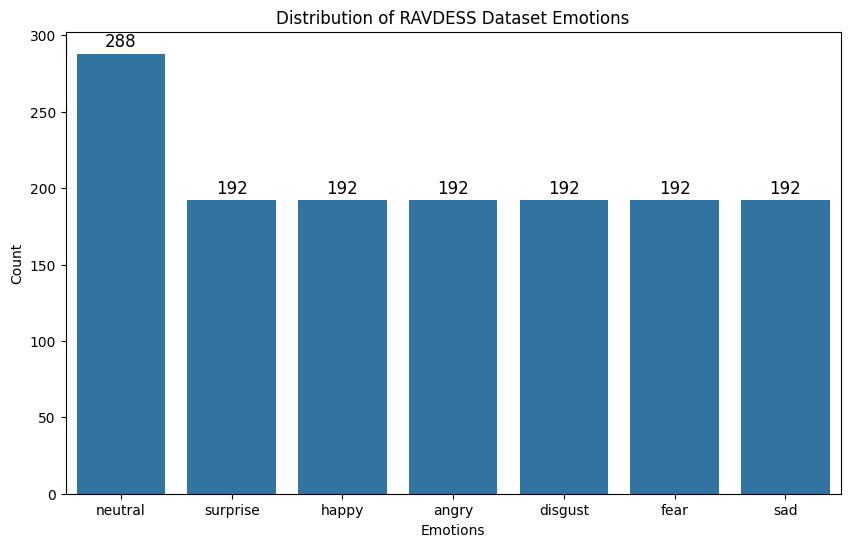

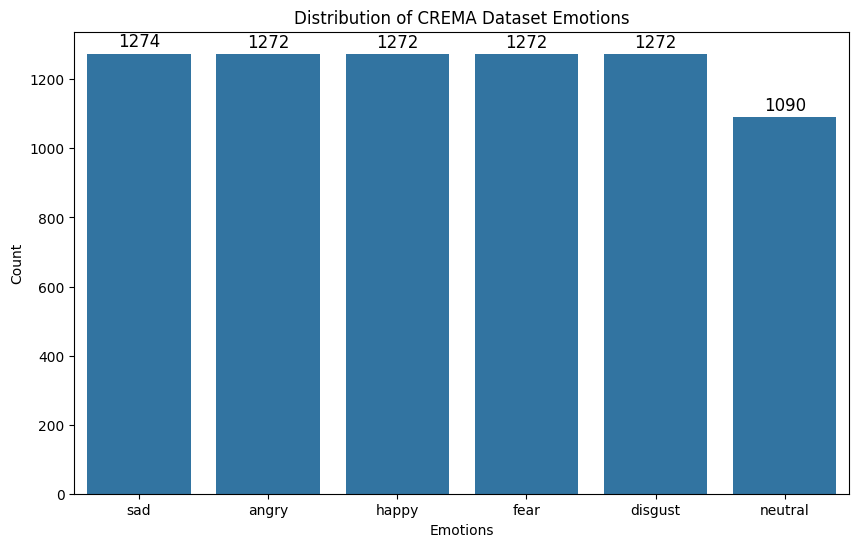

In [ ]:

# Function to plot the Bar Graph
def plot_emotion_counts(df, title):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x='Emotions', order=df['Emotions'].value_counts().index)

    # Add counts on top of each bar, formatted as integers
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.title(title)
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.show()

# Calling the function to plot the dataframes
plot_emotion_counts(Ravdess_df, 'Distribution of RAVDESS Dataset Emotions')
plot_emotion_counts(Crema_df, 'Distribution of CREMA Dataset Emotions')



In [ ]:
# creating a common dataframe
data_path = pd.concat([Ravdess_df], axis = 0)
#data_path = pd.concat([Crema_df], axis = 0)

data_path.head()

Emotions                                               Path
0  surprise  /content/drive/My Drive/Data/Ravdess/audio_spe...
1     happy  /content/drive/My Drive/Data/Ravdess/audio_spe...
2     angry  /content/drive/My Drive/Data/Ravdess/audio_spe...
3   neutral  /content/drive/My Drive/Data/Ravdess/audio_spe...
4   disgust  /content/drive/My Drive/Data/Ravdess/audio_spe...

In [ ]:
print(data_path.Emotions.value_counts())


Emotions
neutral     288
surprise    192
happy       192
angry       192
disgust     192
fear        192
sad         192
Name: count, dtype: int64


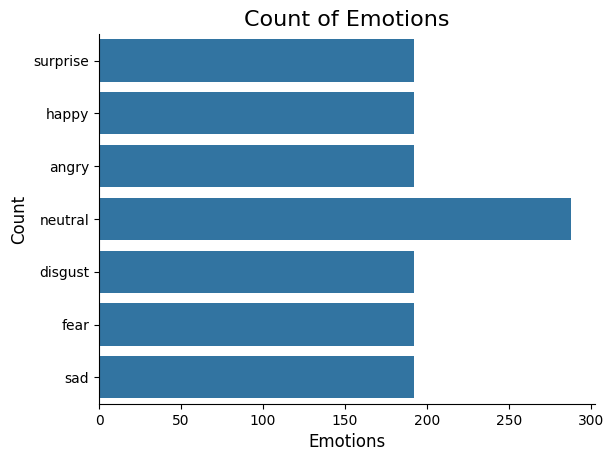

In [ ]:
# Displaying count of emotions of the selected dataset
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

Waveplots let us know the loudness of the audio at a given time.
spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:

# Creating functions for waveplot and spectogram
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

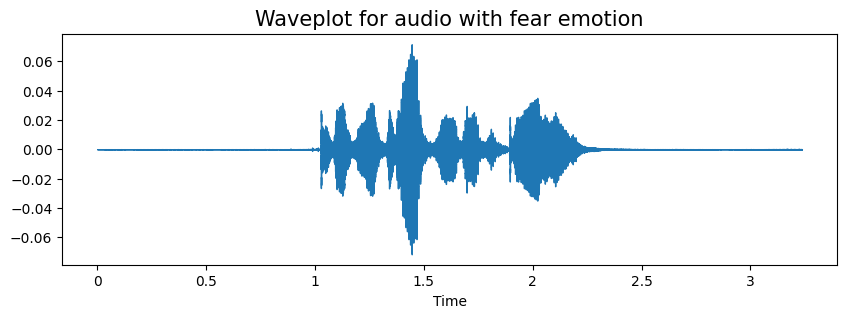

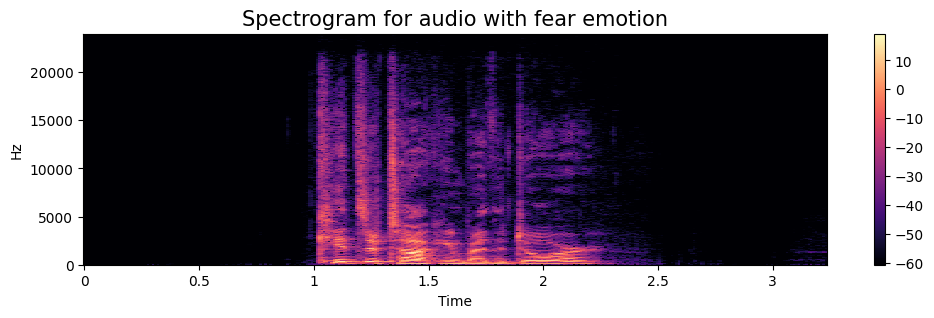

In [ ]:
# Waveplot and Spectogram for the audio sample of 'Fear'
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


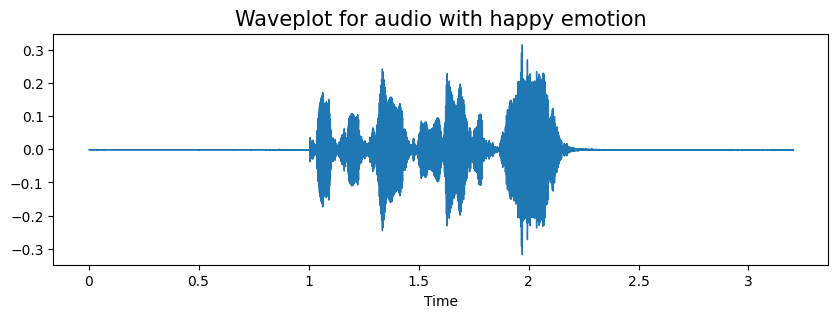

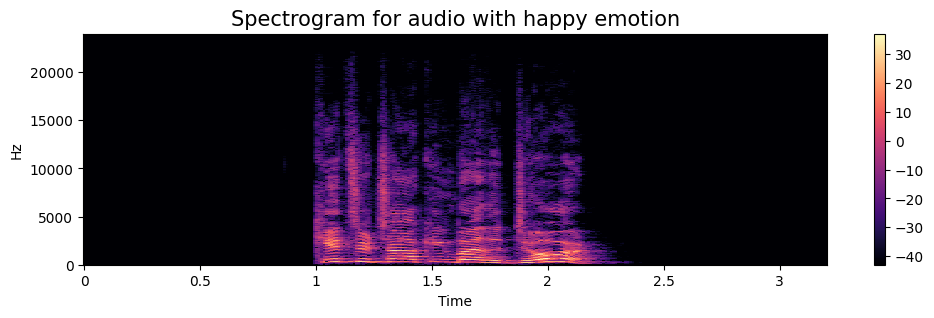

In [ ]:
# Waveplot and Spectogram for the audio sample of 'Fear'
emotion = 'happy'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

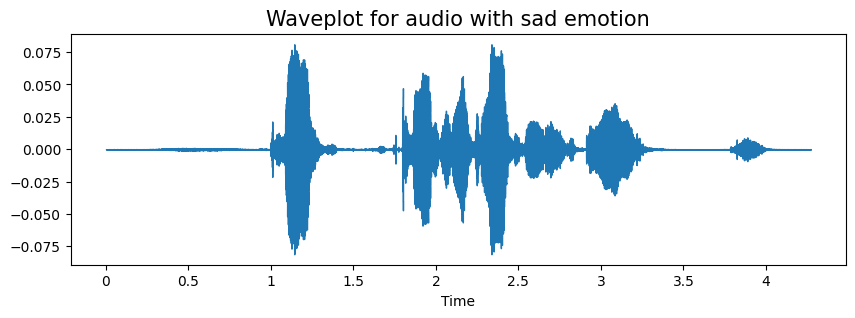

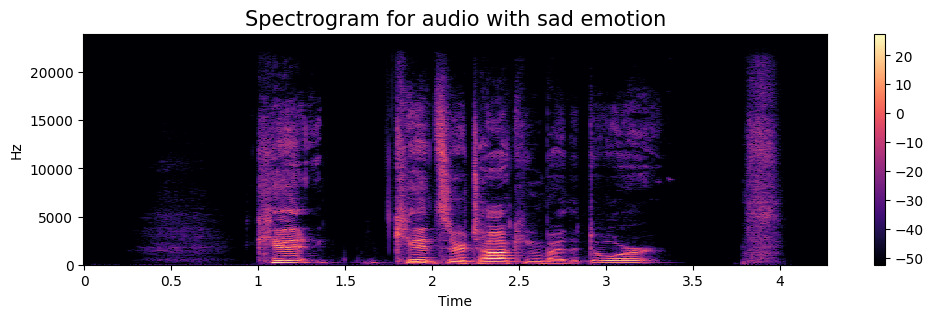

In [ ]:
# Waveplot and Spectogram for the audio sample of 'Fear'
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

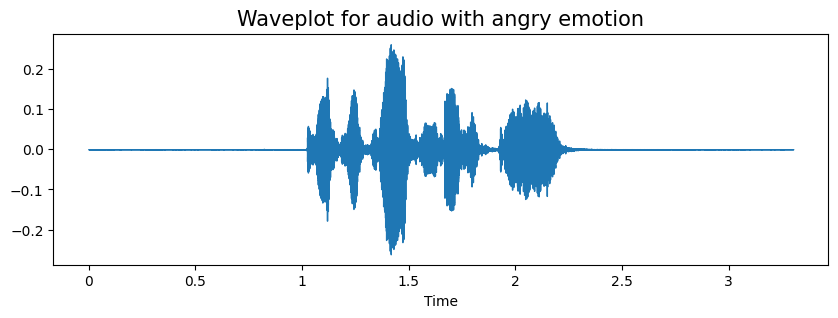

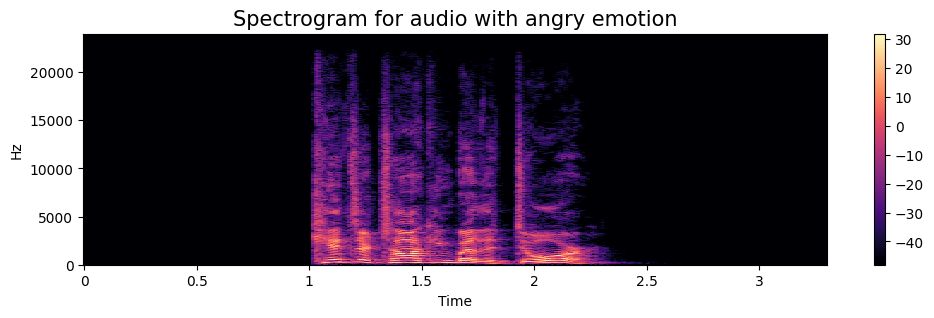

In [ ]:
# Waveplot and Spectogram for the audio sample of 'Sad'
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
# Load the audio file
data, sr = librosa.load(path, sr=None)

Data Preprocessing

Trimming the original audio input to remove the non speech parts of the audio.


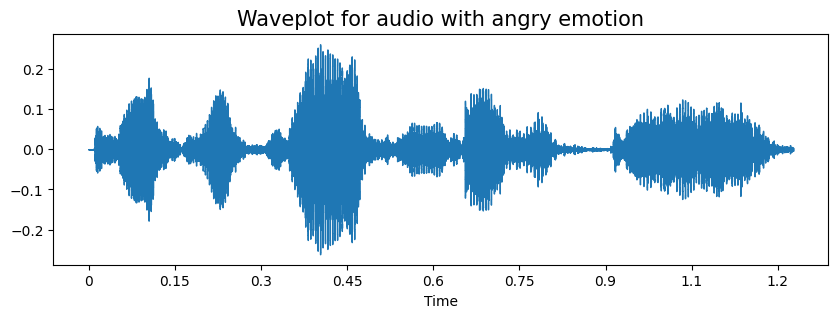

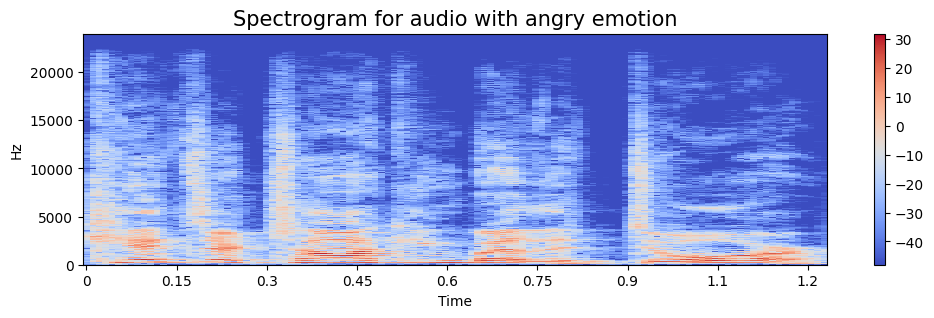

In [ ]:
def trim_silence(y, top_db=30):
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed


# Waveplot and Spectogram for the audio sample of 'Happy'
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sr = librosa.load(path, sr=None)

data = trim_silence(data)

# Create the waveplot and spectrogram
create_waveplot(data, sr, emotion)
create_spectrogram(data, sr, emotion)

# Play the audio
Audio(path)

Emotions
neutral     288
surprise    192
happy       192
angry       192
disgust     192
fear        192
sad         192
Name: count, dtype: int64


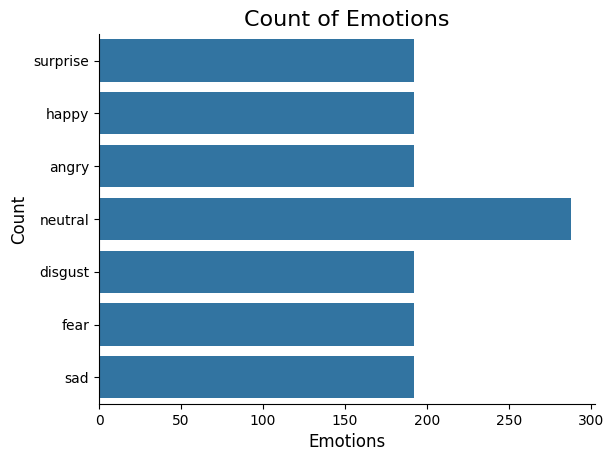

In [ ]:
print(data_path.Emotions.value_counts())

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

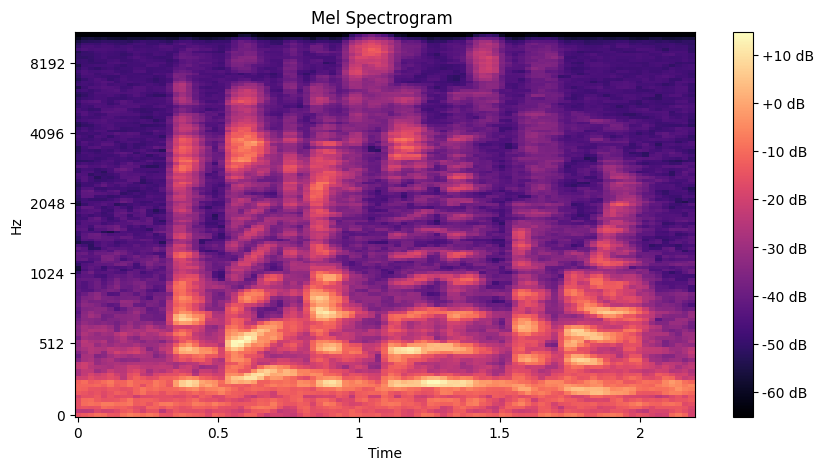

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

In [ ]:
ipd.Audio(data,rate=sr)

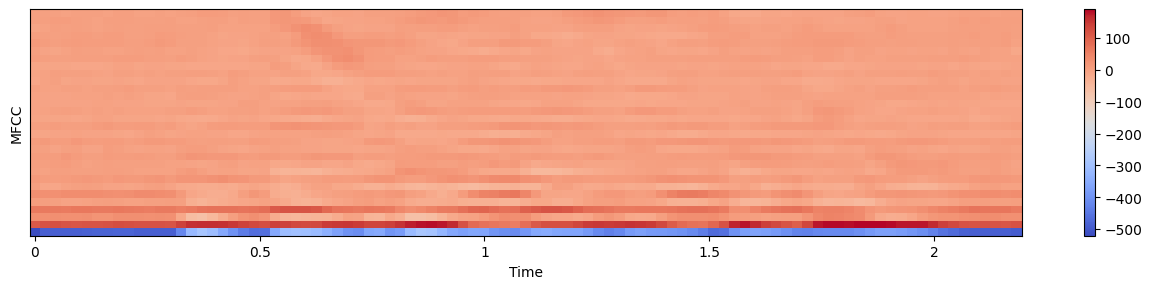

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# Mel-Frequency Cepstral Coefficients mimics hwo human hear and process audio

plt.figure(figsize=(16, 10))
plt.title('MFCC Graph')
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

Data Augmentation

In [ ]:
# Noise Injection
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Time Stretch
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# Time Shifting
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Pitch Shifting
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

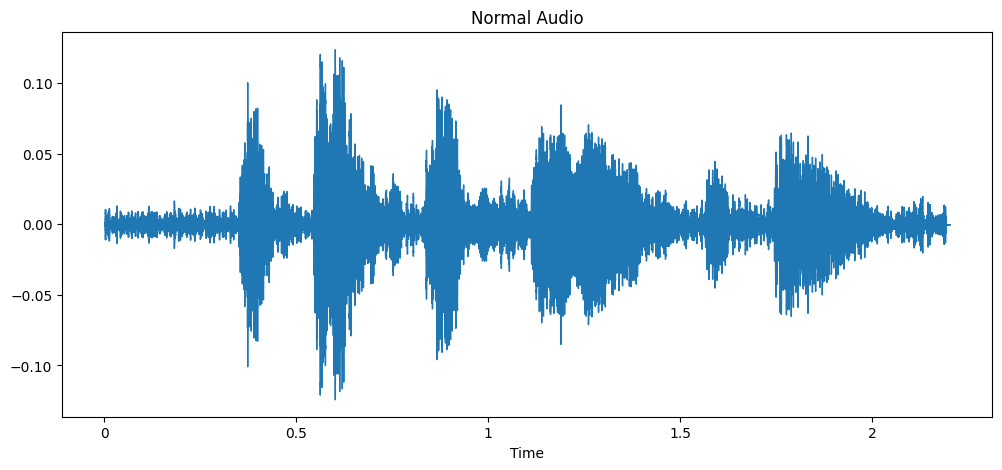

In [ ]:
# Normal Audio

plt.figure(figsize=(12, 5))
plt.title('Normal Audio')
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

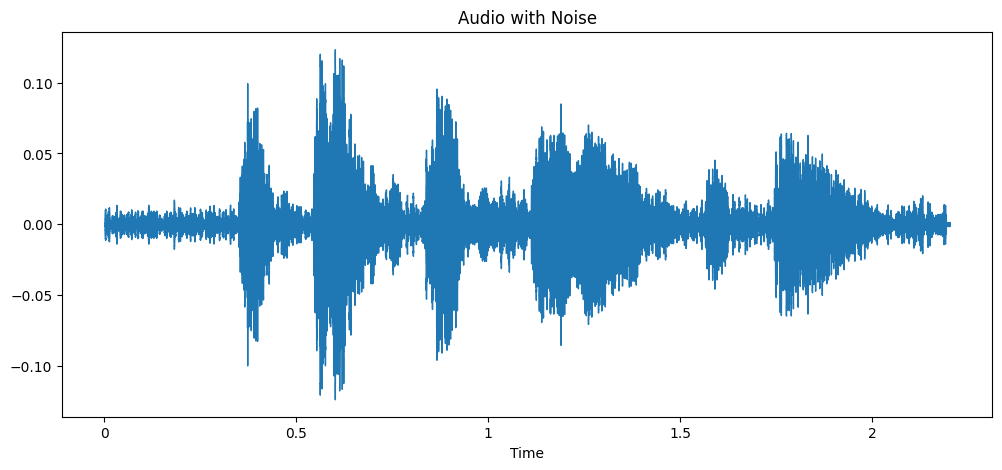

In [ ]:
# Audio With Noise

x = noise(data)
plt.figure(figsize=(12,5))
plt.title('Audio with Noise')
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

<ipython-input-82-31d616a81241>:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)


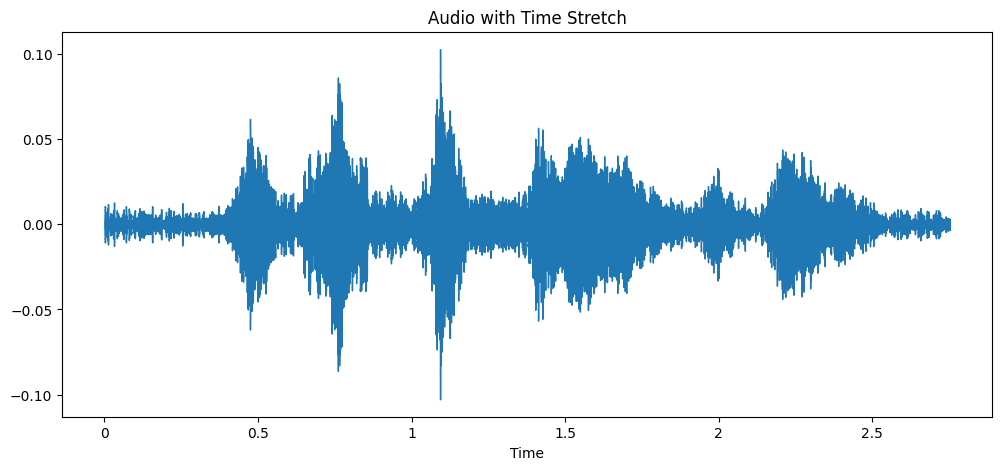

In [ ]:
# Time Stretch

x = stretch(data)
plt.figure(figsize=(12, 5))
plt.title('Audio with Time Stretch')
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

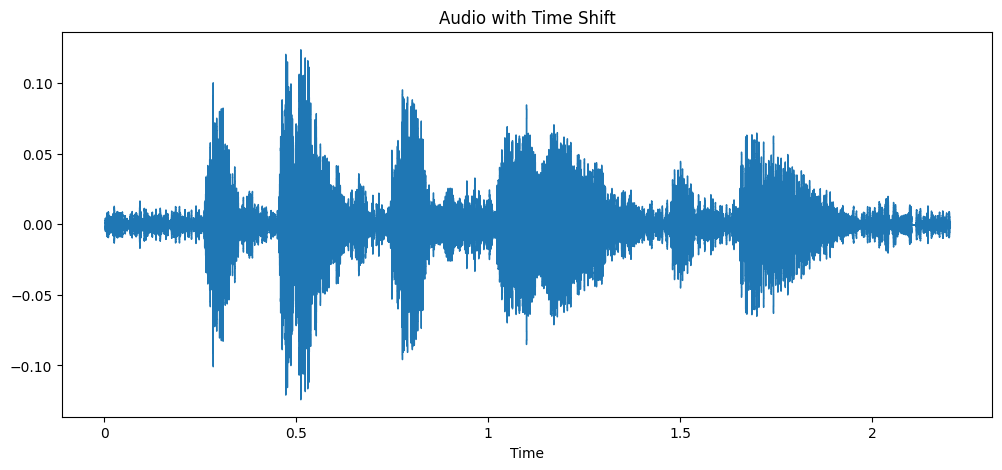

In [ ]:
# Time Shifting

x = shift(data)
plt.figure(figsize=(12,5))
plt.title('Audio with Time Shift')
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

<ipython-input-82-31d616a81241>:18: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


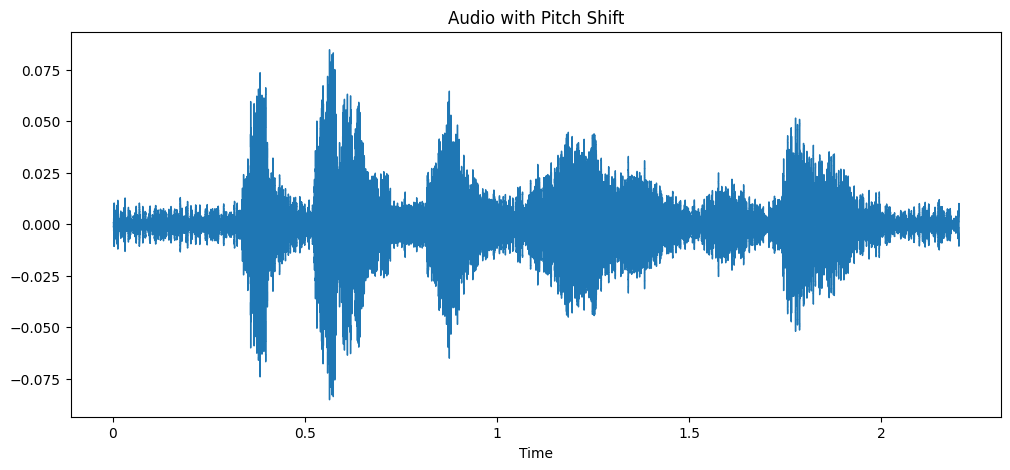

In [ ]:
# Pitch Shift

x = pitch(data, sr)
plt.figure(figsize=(12, 5))
plt.title('Audio with Pitch Shift')
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

Feature Extraction

In [ ]:
# Zero Crossing Rate, to identify emotions that involve rapid changes in sound
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# Root Mean Square Energy, to measure the intensity of the speech signal
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
# Mel-Frequency Cepstral Coefficients, to capture the speech features most relevant to human perception
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [ ]:
#import timeit
#from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

0it [00:00, ?it/s]<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.8750706e-06
 -1.7649594e-07  1.3507882e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
<ipython-input-88-adc402d39df5>:8: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.8750706e-06
 -1.7649594e-07  1.3507882e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[ 0.00029642  0.00241639  0.00061112 ...  0.00228946 -0.000609
  0.00490104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
<ipython-input-88-adc402d39df5>:8: FutureWarnin

0 audio has been processed


Streaming output truncated to the last 5000 lines.
 -1.6133186e-05  4.5267611e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[ 0.0004725   0.00151598 -0.00021243 ... -0.00121696 -0.00669946
  0.00087773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
<ipython-input-88-adc402d39df5>:8: FutureWarning: Pass y=[ 0.0004725   0.00151598 -0.00021243 ... -0.00121696 -0.00669946
  0.00087773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[-1.9110687e-06  9.1580932e-06  4.1992778e-05 ...  1.2420432e-04
  8.6506967e-05  7.9879726e-05] as keyword args. From version 0.10 pass

500 audio has been processed


Streaming output truncated to the last 5000 lines.
  0.0244181 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[-5.6412595e-05 -6.4473221e-05 -4.5145371e-05 ...  2.9422738e-02
  2.1581247e-02  1.3950986e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
<ipython-input-88-adc402d39df5>:8: FutureWarning: Pass y=[-5.6412595e-05 -6.4473221e-05 -4.5145371e-05 ...  2.9422738e-02
  2.1581247e-02  1.3950986e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[-0.00175404  0.00082073  0.00119847 ...  0.02887999  0.02164896
  0.01587706] as keyword args. From version 0.10 pass

1000 audio has been processed


Streaming output truncated to the last 5000 lines.
  0.00022768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
1231it [17:21,  1.16it/s]<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[-1.5253841e-07  1.5650315e-07 -1.4778276e-07 ...  1.6717416e-07
 -4.6577952e-06 -1.2618164e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
<ipython-input-88-adc402d39df5>:8: FutureWarning: Pass y=[-1.5253841e-07  1.5650315e-07 -1.4778276e-07 ...  1.6717416e-07
 -4.6577952e-06 -1.2618164e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(data,sr=sr)
<ipython-input-88-adc402d39df5>:5: FutureWarning: Pass y=[ 0.00127274 -0.0004073   0.00223839 ... -0.00087026  0.0007845
  0.0018049 ] as keyword args

Done
Time:  1223.8526298800025


In [ ]:
# Creating a csv file for further processing of data

Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y

Emotions.to_csv('/content/drive/My Drive/FinalCSVs/Ravdessnew.csv', index=False)
#Emotions.to_csv('/content/drive/My Drive/FinalCSVs/Crema.csv', index=False)
print(Emotions.isna().any())
Emotions.head()

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


0         1         2         3         4         5         6  \
0  0.000000  0.039062  0.039062  0.039062  0.047852  0.211426  0.303711   
1  0.260742  0.379395  0.512695  0.514648  0.492188  0.499023  0.498047   
2  0.000000  0.004883  0.104004  0.200684  0.287598  0.391113  0.406250   
3  0.246582  0.367676  0.486328  0.480469  0.480469  0.479004  0.477539   
4  0.295898  0.398926  0.536621  0.523438  0.485352  0.496582  0.511719   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.436523  0.581055  0.570312  ...  3.897274  3.835110  3.768318  3.697085   
1  0.493652  0.501465  0.506348  ... -1.296671 -1.054297 -1.985939 -0.528425   
2  0.392578  0.415527  0.428223  ...  0.531179  0.527176  0.522848  0.518198   
3  0.475098  0.481934  0.490234  ... -1.048533  2.139041  7.313325  4.761428   
4  0.525879  0.493164  0.485352  ...  0.000000  0.000000  0.000000  0.000000   

       2371      2372      2373      2374      2375  Emotions  
0  3.621608  3.542110  3.458778  3.371874  3.281625  surprise  
1  5.428215 -1.818451 -9.639478 -3.360710 -1.336673  surprise  
2  0.513229  0.507948  0.502369  0.496490  0.490317  surprise  
3  3.293701  2.732764 -1.598649  1.562840  2.657444  surprise  
4  0.000000  0.000000  0.000000  0.000000  0.000000     happy  

[5 rows x 2377 columns]

In [ ]:
Emotions = pd.read_csv('/content/drive/My Drive/FinalCSVs/Ravdess.csv')
Emotions.head()

Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [ ]:
# Preprocessing Data for Model Input

# Extract the feature matrix (X) and the target labels (Y) from the dataframe
# X contains all columns except the last one (emotions), and Y contains only the 'Emotions' column
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

# Initialize a OneHotEncoder to convert the categorical emotion labels into a one-hot encoded format
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Splitting the dataset into training and testing sets
# 80% of the data is used for training, and 20% is used for testing.
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)

# Print the shapes of the training and testing datasets
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Reshape the training and testing feature matrices to be compatible with the CNN input
# CNNs typically expect input data in the form (samples, timesteps, features)
# Here, we add a third dimension to represent the single feature (1D time-series data)
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

(4608, 2376) (4608, 7) (1152, 2376) (1152, 7)


In [ ]:
# Initializing a StandardScaler to normalize the features in the dataset
# StandardScaler standardizes the features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Fitting the StandardScaler on the training data and transform the training and testing data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Printing the shapes of the training and testing datasets to confirm they remain consistent
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Expand the dimensions of the training and testing datasets to make it compatible with the CNN model
# CNNs in Keras expect input data in a 3D shape: (samples, timesteps, features)
# Here, axis=2 indicates that we are adding a new axis as the last dimension
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

# Print the shapes of the transformed training and testing data along with their labels
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((4608, 2376, 1), (4608, 7), (1152, 2376, 1), (1152, 7))

In [ ]:
# Proposed Hybrid Model integrating 1D CNN(One Branch) and BiLSTM-Transformer(Second Branch) models

# Transformer block class to be used in the BiLSTM-Transformer branch

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Multi-Head Attention layer for capturing relationships between different parts of the input sequence
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-Forward Network (FFN) layers for additional processing after attention
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        # Layer Normalization to stabilize the training process
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout layers to prevent overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply Layer Normalization to the combined output.
        return self.layernorm2(out1 + ffn_output)

# Callbacks to monitor the training process
# ModelCheckpoint saves the best model based on validation accuracy.
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/FinalCSVs/best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
# EarlyStopping stops training if validation accuracy doesn't improve after a few epochs to prevent overfitting
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
# To adjust the learning rate during training when the performance of the model stops improving
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# First branch - Convolutional layers
input_cnn = tf.keras.layers.Input(shape=(X_train.shape[1], 1))

# First Conv1D layer with 512 filters, a kernel size of 5, and ReLU activation. This layer extracts local features from the input data
x = tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(input_cnn)
# Batch Normalization to stabilize the learning process and speed up convergence by normalizing the output of the previous layer
x = tf.keras.layers.BatchNormalization()(x)
# Max Pooling layer to reduce the dimensionality of the feature maps, keeping the most significant information while reducing computational load
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)

# Second Conv1D layer, similar to the first, continuing to extract higher-level features from the data
x = tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting by randomly setting 20% of the input units to 0 during training
x = tf.keras.layers.Dropout(0.2)(x)

# Third Conv1D layer with 256 filters and a kernel size of 5. This layer continues to refine feature extraction
x = tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)

# Fourth Conv1D layer with 256 filters and a smaller kernel size of 3, focusing on finer features in the data
x = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Fifth Conv1D layer with 128 filters and a kernel size of 3, capturing even more granular details from the data
x = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Flatten the 3D output from the convolutional layers into a 1D vector, preparing it for dense layers or concatenation with another branch
x_cnn = tf.keras.layers.Flatten()(x)

# Second branch - BiLSTM and Transformer layers
# Define the input shape for the BiLSTM branch, with X_train.shape[1] representing the time steps and 1 feature
input_bilstm = tf.keras.layers.Input(shape=(X_train.shape[1], 1))

# Bidirectional LSTM layer with 64 units to capture dependencies in both forward and backward directions
# This helps in understanding the sequential nature of the speech data, capturing both past and future context
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(input_bilstm)

# Set up parameters for the Transformer block.
embed_dim = 128  # To control the size of the output space.
num_heads = 4    # Number of attention heads in the multi-head attention mechanism
ff_dim = 512     # Dimensionality of the feed-forward network inside the transformer block

# Ensure the output of BiLSTM is suitable for the transformer blocks
y = tf.expand_dims(y, axis=1)  # Expand dims to fit transformer input

for _ in range(3):
    y = TransformerBlock(embed_dim, num_heads, ff_dim)(y)

# Flatten the output from the transformer blocks to concatenate it with CNN Branch output
y = tf.keras.layers.Flatten()(y)

# Concatenate both branches
combined = tf.keras.layers.concatenate([x_cnn, y])

# Dense layer with 64 units and ReLU activation to learn combined features from both branches
z = tf.keras.layers.Dense(64, activation='relu')(combined)

# Dropout layer to prevent overfitting
z = tf.keras.layers.Dropout(0.5)(z)

# Layer Normalization to stabilize the training process by normalizing the combined output
z = tf.keras.layers.LayerNormalization()(z)

# Output layer with softmax activation to produce probability distributions over the emotion classes
output = tf.keras.layers.Dense(len(data_path.Emotions.unique()), activation='softmax')(z)

# Model definition combining both branches and specifying input and output layers
model = tf.keras.Model(inputs=[input_cnn, input_bilstm], outputs=output)

# Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Plot the model and save it as an image file
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Model training
history = model.fit(
    [x_traincnn, x_traincnn], y_train,  # Assuming both inputs are the same here for simplicity
    epochs=20, # Number of training EPochs
    validation_data=([x_testcnn, x_testcnn], y_test), # Validation data
    batch_size=64, # Batch size for training
    callbacks=[early_stop, lr_reduction, model_checkpoint] # Callbacks to monitor the training process
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2376, 1)]            0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 2376, 512)            3072      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 2376, 512)            2048      ['conv1d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 1188, 512)            0         ['batch_normalization_10

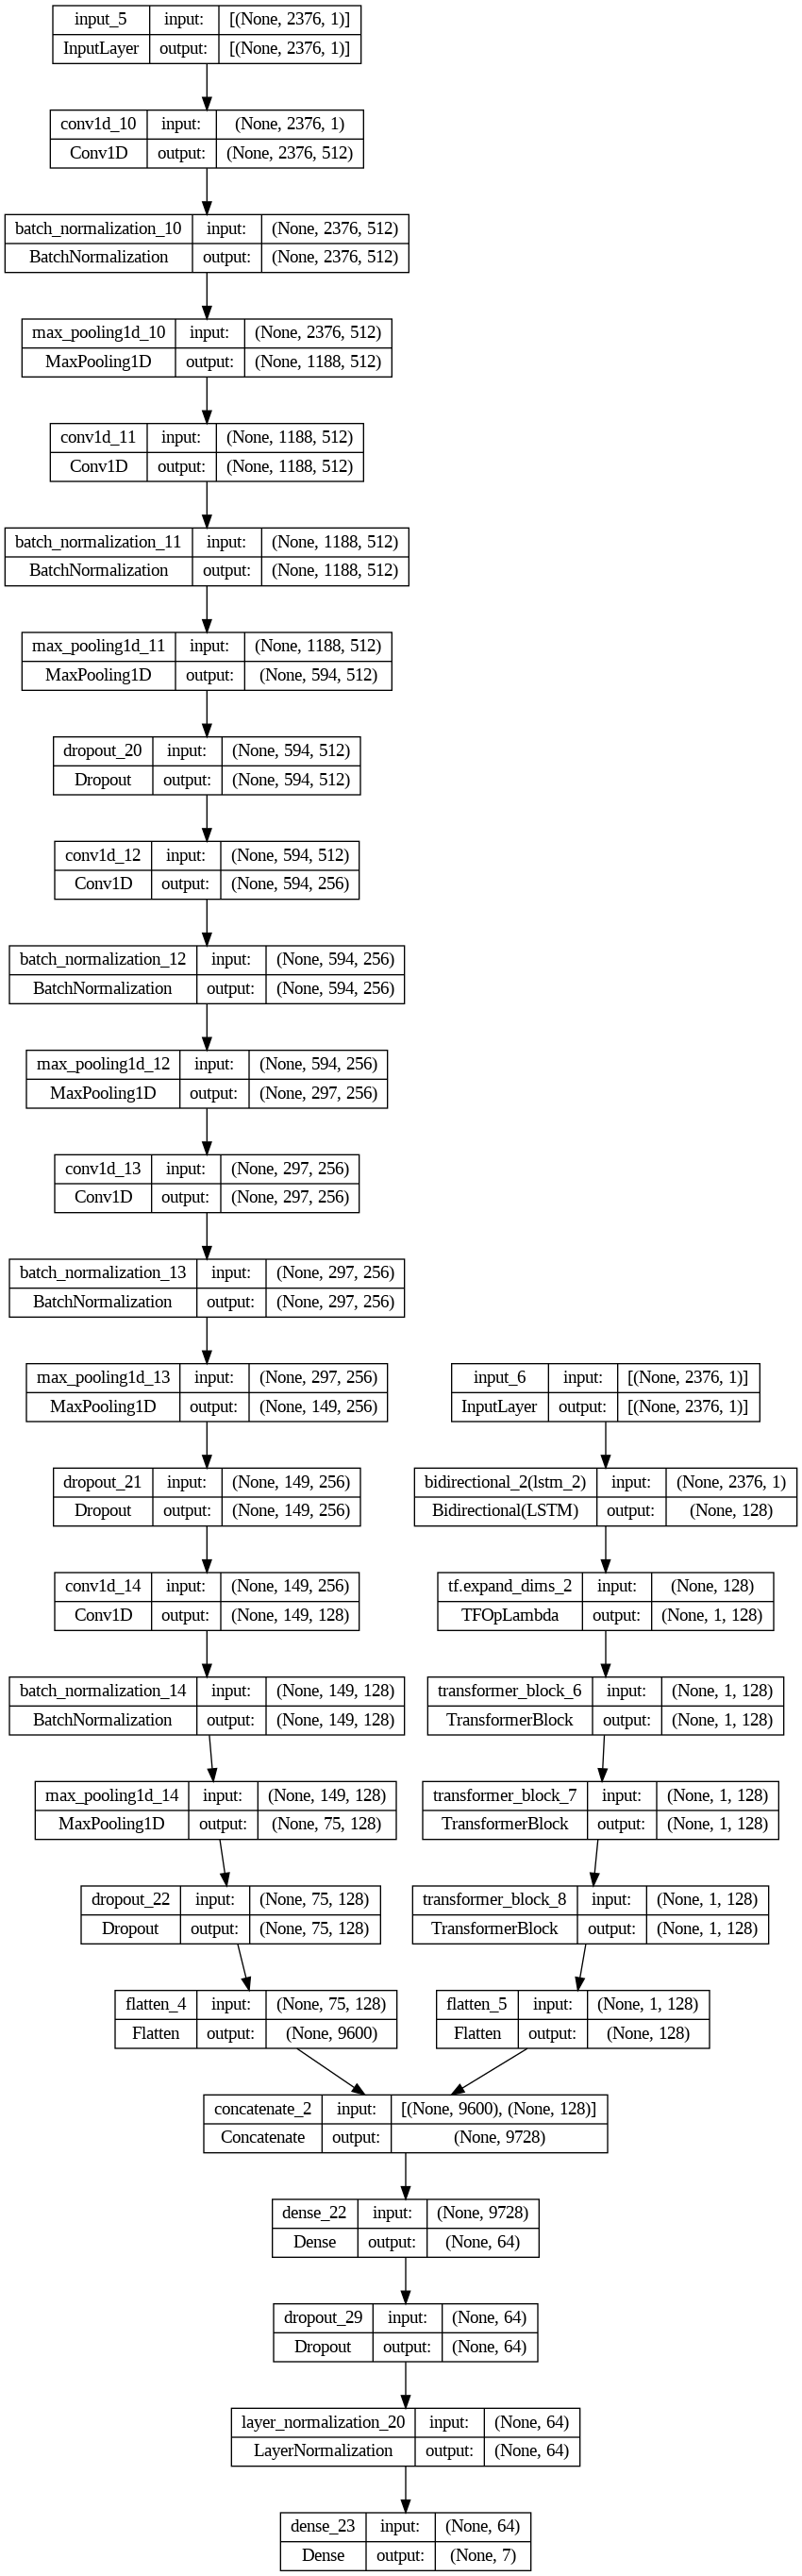

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Model Evaluation

In [ ]:
# Function to plot Traing Vs Validation Accuracy graph
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Function to Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Function to print classification report with metrics
def classification_report_with_metrics(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

# Function to print overall precision, recall, and F1 score
def overall_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Overall Precision: {precision:.2f}")
    print(f"Overall Recall: {recall:.2f}")
    print(f"Overall F1 Score: {f1:.2f}")

36/36 [==============================] - 5s 104ms/step


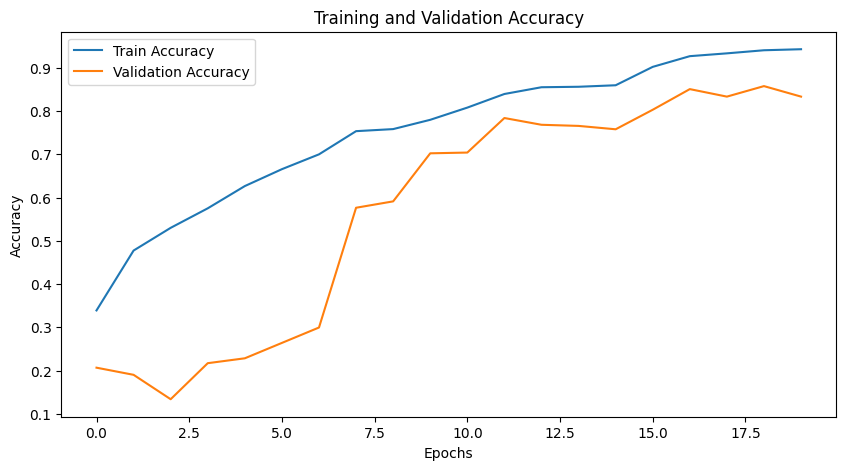

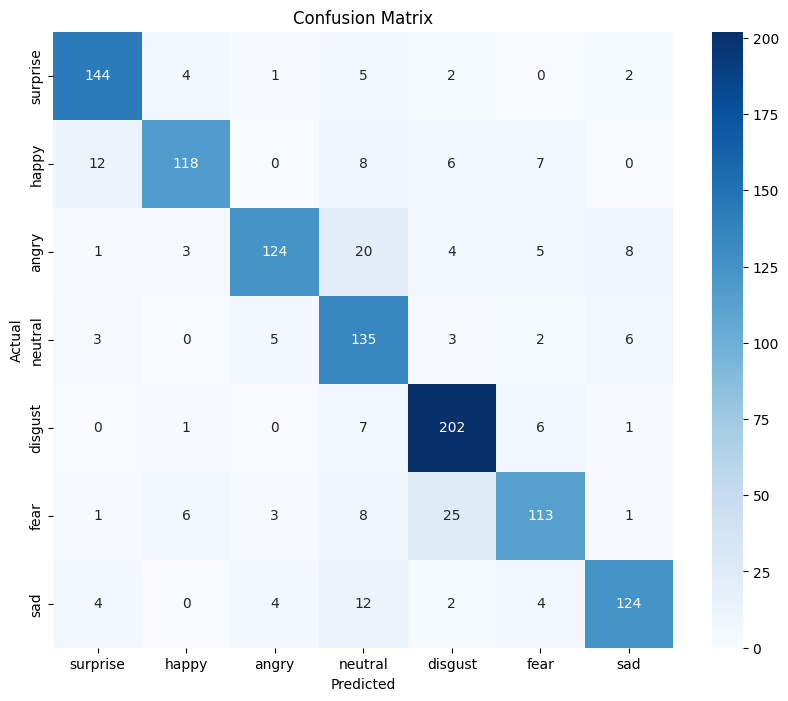

Overall Precision: 0.84
Overall Recall: 0.83
Overall F1 Score: 0.83


precision    recall  f1-score      support
surprise       0.872727  0.911392  0.891641   158.000000
happy          0.893939  0.781457  0.833922   151.000000
angry          0.905109  0.751515  0.821192   165.000000
neutral        0.692308  0.876623  0.773639   154.000000
disgust        0.827869  0.930876  0.876356   217.000000
fear           0.824818  0.719745  0.768707   157.000000
sad            0.873239  0.826667  0.849315   150.000000
accuracy       0.833333  0.833333  0.833333     0.833333
macro avg      0.841430  0.828325  0.830682  1152.000000
weighted avg   0.841115  0.833333  0.833066  1152.000000

In [ ]:
y_pred = model.predict([x_testcnn, x_testcnn])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

classes = data_path.Emotions.unique()

# Plot the accuracy graph
plot_accuracy(history)

# Plot the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, classes)

# Print overall precision, recall, and F1 score
overall_metrics(y_true_classes, y_pred_classes)

# Print the classification report with metrics
classification_report_with_metrics(y_true_classes, y_pred_classes, classes)